# Explaining XGBoost model predictions with Shapley values

## Aims:

* Fit XGBoost model to k-fold train/test splits.
* Get Shap values for each k-fold split.
* Examine consistency of Shap values across k-fold splits.
* Examine consistency of XGBoost Importance across k-fold splits.
* Compare Shap values and XGBoost Importance.
* Further analyse Shap values with:
    * Beeswarm plots
    * Waterfall plots
    * Scatter plots
* Show example of Shap waterfall plot as *probability* rather than *log odds ratio*.

## Aims

The aim of this notebook are:

* Examine consistency of Shap values across 5 k-fold replications.
* Examine consistency of XGBoost *Importance* values across 5 k-fold replications.
* Compare Shap values and XGBoost *Importance* values.
* Further investigate the relationship between features and Shap values with:
    * Beeswarm plots
    * Waterfall plots
    * Scatter plots
* Provide an example of plotting Shap values as probabilities rather than log odds-ratios.

### Note on shap version 0.40:

Installed using `pip install shap`

There is a bug in the waterfall plot where `show=False` (required to save plot) fails. To correct this find the `_waterfall.py` file in the shap library (e.g. in `anaconda/envs/samuel2/lib/python3.8/site-packages/shap/plots`, and search/replace all `pl.` to `.plt`, and replace initial import of `import matplotlib.pyplot as pl` with `import matplotlib.pyplot as plt`.

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from xgboost import XGBClassifier

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [2]:
data_loc = '../data/kfold_5fold/'

train_data, test_data = [], []

# Load features (and add S2Thrombolysis)
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')

for i in range(5):
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train_data.append(train)
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test_data.append(test)

## Fit XG Boost model

Fit model and get feature importances for each k-fold training/test split.

In [3]:
fit_models = True # Otherwise load models

# Set up lists for k-fold fits
model_kfold = []
importances_kfold = []
y_pred_kfold = []
y_prob_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []


for k in range(5):
    # Get X and y
    X_train = train_data[k].drop('S2Thrombolysis', axis=1)
    X_test = test_data[k].drop('S2Thrombolysis', axis=1)
    y_train = train_data[k]['S2Thrombolysis']
    y_test = test_data[k]['S2Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('StrokeTeam', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('StrokeTeam', axis=1, inplace=True)
    
    # Store processed X and y
    X_train_kfold.append(X_train)
    X_test_kfold.append(X_test)
    y_train_kfold.append(y_train)
    y_test_kfold.append(y_test)
    
    if fit_models:       

        # Define and Fit model
        model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
        model.fit(X_train, y_train)
        model_kfold.append(model)

        # Save using pickle
        filename = f'./saved_models/combined_xgb_model_key_features_{k}.p'
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)
    
    else:
        filename = f'./saved_models/combined_xgb_model_key_features_{k}.p'
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
            model_kfold.append(model)        

    # Get feature weights
    features = list(X_train)
    feature_importances = model.feature_importances_
    importances = pd.DataFrame(index=features)
    importances['importance'] = feature_importances
    importances['rank'] = importances['importance'].rank(ascending=False).values
    importances_kfold.append(importances)

    # Get predicted class and ptrobability
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_prob_kfold.append(y_prob)

    # Measure accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f'Accuracy k-fold {k+1}: {accuracy:0.3f}')

Accuracy k-fold 1: 0.846
Accuracy k-fold 2: 0.853
Accuracy k-fold 3: 0.845
Accuracy k-fold 4: 0.849
Accuracy k-fold 5: 0.844


## Shap values

We will look into detailed Shap values for the first train/test split.

### Get Shap values

In [4]:
calculate_shap_values = True # Otherwise load Shap values

k_fold_shap_values_extended = []
k_fold_shap_values = []

for k in range(5):

    if calculate_shap_values:

        # Set up explainer using typical feature values from training set
        explainer = shap.TreeExplainer(model_kfold[k], X_train_kfold[k])

        # Get Shapley values along with base and features
        shap_values_extended = explainer(X_test_kfold[k])
        k_fold_shap_values_extended.append(shap_values_extended)
        # Shap values exist for each classification in a Tree; 1=give thrombolysis
        shap_values = shap_values_extended.values
        k_fold_shap_values.append(shap_values)        

        # Save using pickle
        filename = f'./output/shap_values_extended_xgb_key_features_{k}.p'
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
            
        print (f'Completed {k+1} of 5')
        
    else:
        # Load preloaded explainer
        filename = f'./output/shap_values_extended_xgb_key_features_{k}.p'
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            k_fold_shap_values_extended.append(shap_values_extended)
            k_fold_shap_values.append(shap_values_extended.values)

 97%|=================== | 17297/17759 [00:24<00:00]       

Completed 1 of 5


 99%|===================| 17645/17759 [00:24<00:00]        

Completed 2 of 5


 99%|===================| 17566/17758 [00:23<00:00]        

Completed 3 of 5


 99%|===================| 17593/17758 [00:22<00:00]        

Completed 4 of 5


 98%|===================| 17474/17758 [00:22<00:00]        

Completed 5 of 5


### Get average Shap values for each k-fold

In [5]:
shap_values_mean_kfold = []

for k in range(5):
    shap_values = k_fold_shap_values[k]
    # Get mean Shap values for each feature
    shap_values_mean = pd.DataFrame(index=features)
    shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
    shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
    shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
    shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
        ascending=False).values
    shap_values_mean.sort_index()
    shap_values_mean_kfold.append(shap_values_mean)

### Examine consistency across top Shap values (mean |Shap|)

'Raw' Shap values from XGBoost model are log odds ratios. 

In [6]:
# Build df for k fold values
mean_abs_shap = pd.DataFrame()
for k in range(5):
    mean_abs_shap[f'{k}'] = shap_values_mean_kfold[k]['mean_abs_shap']
    
# Build df to show min, median, and max
mean_abs_shap_summary = pd.DataFrame()
mean_abs_shap_summary['min'] = mean_abs_shap.min(axis=1)
mean_abs_shap_summary['median'] = mean_abs_shap.median(axis=1) 
mean_abs_shap_summary['max'] = mean_abs_shap.max(axis=1)
mean_abs_shap_summary.sort_values('median', inplace=True, ascending=False)

In [7]:
top_10_shap = list(mean_abs_shap_summary.head(10).index)

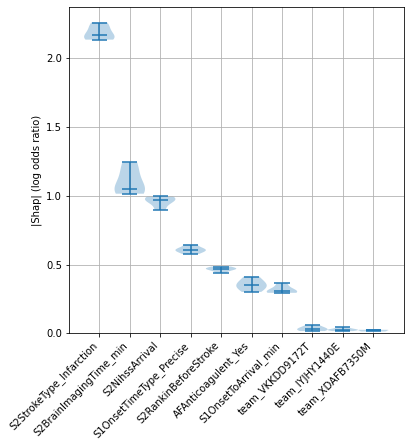

In [8]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(mean_abs_shap.loc[top_10_shap].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_shap
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('|Shap| (log odds ratio)')
plt.savefig('output/shap_violin_key_features.jpg', dpi=300)
plt.show()

### Examine consitency of feature importances

In [9]:
# Build df for k fold values
importances_df = pd.DataFrame()
for k in range(5):
    importances_df[f'{k}'] = importances_kfold[k]['importance']

# Build df to show min, median, and max
importances_summary = pd.DataFrame()
importances_summary['min'] = importances_df.min(axis=1)
importances_summary['median'] = importances_df.median(axis=1) 
importances_summary['max'] = importances_df.max(axis=1)
importances_summary.sort_values('median', inplace=True, ascending=False)

In [10]:
top_10_importances = list(importances_summary.head(10).index)

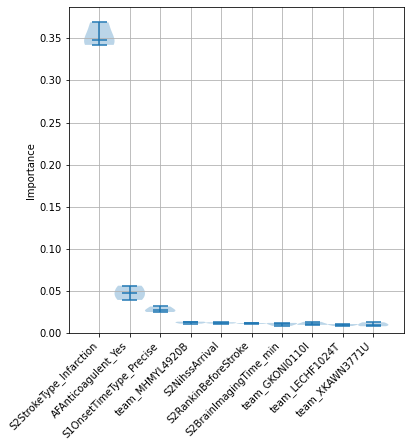

In [11]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(importances_summary.loc[top_10_importances].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_importances
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Importance')
plt.savefig('output/importance_violin_key_features.jpg', dpi=300)
plt.show()

### Compare top 10 Shap and importances

In [12]:
compare_shap_importance = pd.DataFrame()
compare_shap_importance['Shap'] = mean_abs_shap_summary.head(10).index
compare_shap_importance['Importance'] = importances_summary.head(10).index
compare_shap_importance

,Shap,Importance
0,S2StrokeType_Infarction,S2StrokeType_Infarction
1,S2BrainImagingTime_min,AFAnticoagulent_Yes
2,S2NihssArrival,S1OnsetTimeType_Precise
3,S1OnsetTimeType_Precise,team_MHMYL4920B
4,S2RankinBeforeStroke,S2NihssArrival
5,AFAnticoagulent_Yes,S2RankinBeforeStroke
6,S1OnsetToArrival_min,S2BrainImagingTime_min
7,team_VKKDD9172T,team_GKONI0110I
8,team_IYJHY1440E,team_LECHF1024T
9,team_XDAFB7350M,team_XKAWN3771U


In [13]:
shap_importance = pd.DataFrame()
shap_importance['Shap'] = mean_abs_shap_summary['median']
shap_importance = shap_importance.merge(
    importances_summary['median'], left_index=True, right_index=True)
shap_importance.rename(columns={'median':'Importance'}, inplace=True)
shap_importance.sort_values('Shap', inplace=True, ascending=False)
shap_importance.head(10)

,Shap,Importance
S2StrokeType_Infarction,2.167213,0.347804
S2BrainImagingTime_min,1.050302,0.011375
S2NihssArrival,0.971404,0.012466
S1OnsetTimeType_Precise,0.608663,0.027453
S2RankinBeforeStroke,0.469118,0.011766
AFAnticoagulent_Yes,0.351979,0.047754
S1OnsetToArrival_min,0.305040,0.002686
team_VKKDD9172T,0.034521,0.009298
team_IYJHY1440E,0.027590,0.007287
team_XDAFB7350M,0.021129,0.006853


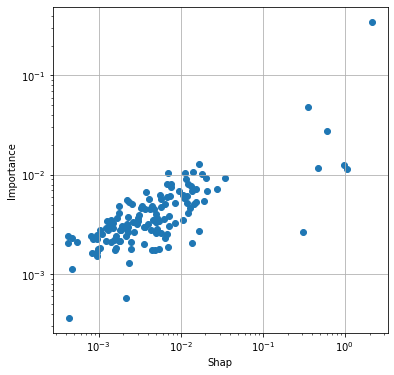

In [14]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(shap_importance['Shap'],
            shap_importance['Importance'])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Shap')
ax1.set_ylabel('Importance')
ax1.grid()
plt.savefig('output/shap_importance_correlation_key_features.jpg', dpi=300)
plt.show()

## Further analysis of one k-fold

Having established that Shap values have good consistency across k-fold replictaes, here we show more detail on Shap using the first k_fold replicate.

In [15]:
# Get all key values from first k fold
model = model_kfold[0]
shap_values = k_fold_shap_values[0]
shap_values_extended = k_fold_shap_values_extended[0]
importances = importances_kfold[0]
y_pred = y_pred_kfold[0]
y_prob = y_prob_kfold[0]
X_train = X_train_kfold[0]
X_test = X_test_kfold[0]
y_train = y_train_kfold[0]
y_test = y_test_kfold[0]

### Beeswarm plot

A Beeswarm plot shows all points. The feature value for each point is shown by the colour, and its position indicates the Shap value for that instance.

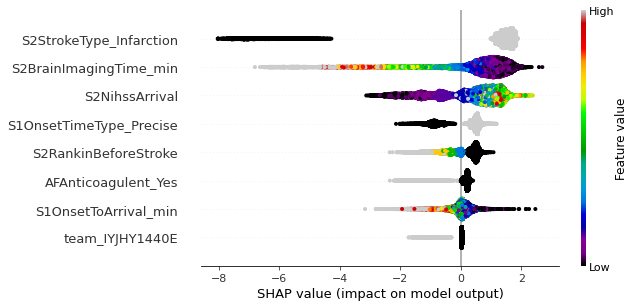

In [16]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=8,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig('output/xgb_beeswarm_key_features.jpg', dpi=300, bbox_inches='tight', 
            pad_inches=0.2)
plt.show()

### Plot Waterfall and decision plot plots for instances with low or high probability of receiving thrombolysis

Waterfall plot and decision plots are alternative ways of plotting the influence of features for individual cases.

In [17]:
# Get the location of an example each where probability of giving thrombolysis
# is <0.1 or >0.9

location_low_probability = np.where(y_prob <0.1)[0][0]
location_high_probability = np.where(y_prob > 0.9)[0][0]

An example with low probability of receiving thrombolysis.

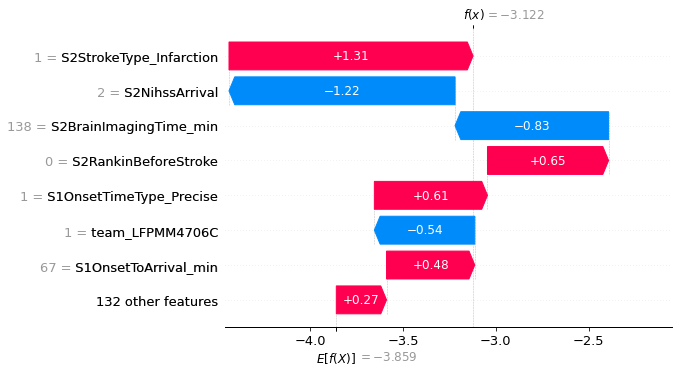

In [18]:
fig = shap.plots.waterfall(shap_values_extended[location_low_probability],
                           show=False, max_display=8)
plt.savefig('output/xgb_waterfall_low_key_features.jpg', dpi=300, bbox_inches='tight',
            pad_inches=0.2)
plt.show()

An example with high probability of receiving thrombolysis.

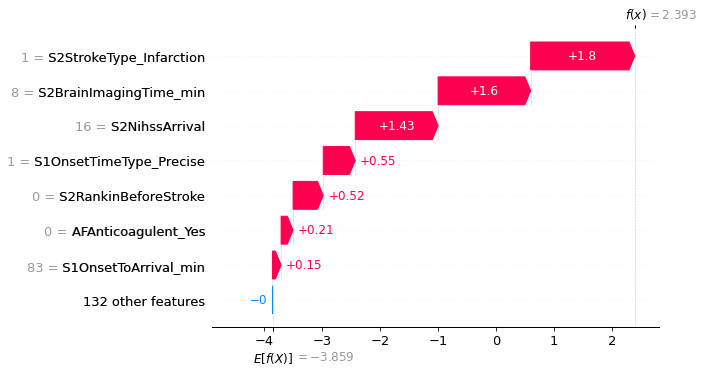

In [19]:
fig = shap.plots.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8)
plt.savefig('output/xgb_waterfall_high_key_features.jpg', dpi=300, bbox_inches='tight',
            pad_inches=0.2)
plt.show()

### Show the relationship between feature value and Shap value for top 5 influential features.

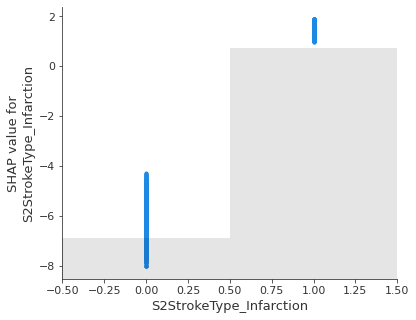

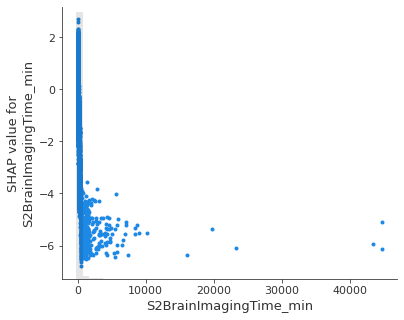

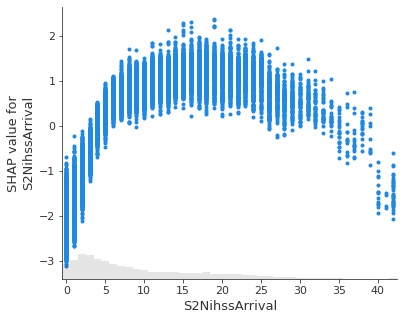

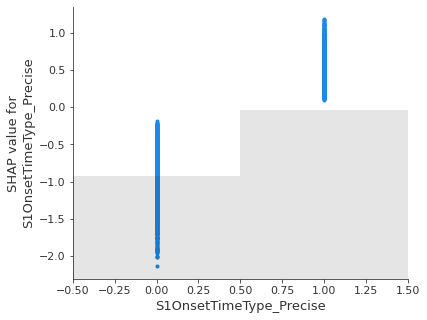

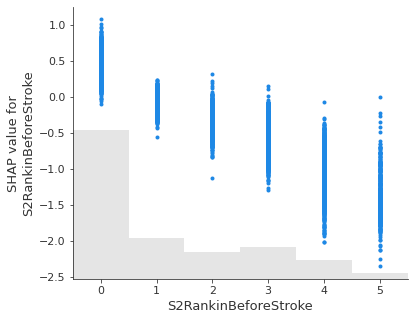

In [20]:
feat_to_show = top_10_shap[0:5]

for feat in feat_to_show:
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0)

Examine `S2BrainImagingTime_min` in range 0-400 minutes.

(0.0, 400.0)

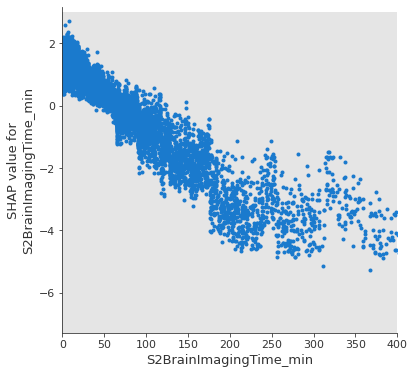

In [21]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
shap.plots.scatter(shap_values_extended[:, 'S2BrainImagingTime_min'], 
                   x_jitter=0, ax=ax, show=False)
ax.set_xlim(0,400)

### Showing waterfall plots using probability values

Though Shap values for XGBoost most accurately describe the effect on log odds ratio of classification, it may be easier for people to understand influence of features using probabilities. Here we plot waterfall plots using probabilities.

A disadvantage of this method is that it distorts the influence of features someone - those features pushing the probability down from a low level to an even lower level get 'squashed' in apparent importance. This distortion is avoided when plotting log odds ratio, but at the cost of using an output that is poorly understandable by many.

In [22]:
# Set up explainer using typical feature values from training set
explainer = shap.TreeExplainer(model, X_train, model_output='probability')

# Get Shapley values along with base and features
shap_values_extended = explainer(X_test)
shap_values = shap_values_extended.values

100%|===================| 17738/17759 [00:29<00:00]        

In [23]:
# Get the location of an example each where probability of giving thrombolysis
# is <0.1 or >0.9

location_low_probability = np.where(y_prob <0.1)[0][0]
location_high_probability = np.where(y_prob > 0.9)[0][0]

An example with low probability of receiving thrombolysis.

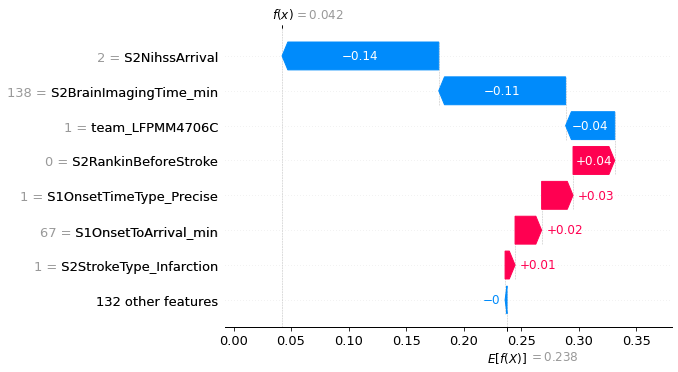

In [24]:
fig = shap.plots.waterfall(shap_values_extended[location_low_probability],
                           show=False, max_display=8)
plt.savefig('output/xgb_waterfall_low_probability_key_features.jpg', dpi=300, bbox_inches='tight',
            pad_inches=0.2)
plt.show()

An example with high probability of receiving thrombolysis.

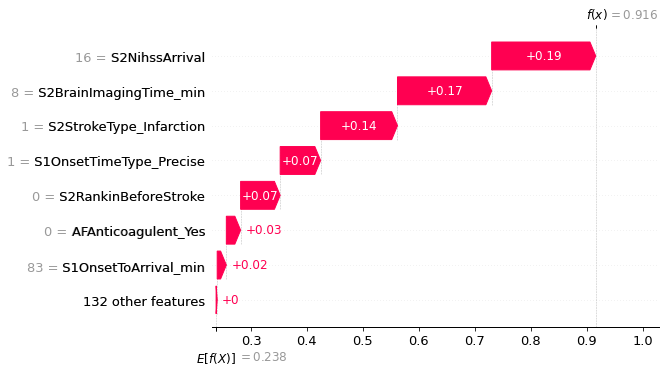

In [25]:
fig = shap.plots.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8)
plt.savefig('output/xgb_waterfall_high_probability_key_features.jpg', dpi=300, bbox_inches='tight',
            pad_inches=0.2)
plt.show()

## Observations

* There was good consiency of Shap values and importances across 5 k-fold replications.
* There was a reasonable correlation between Shap and imortance values, but also some differences in the rank order of importance.
    The five most influential features as judged by Shap were:
    * Stroke type
    * Arrival-to-scan time
    * Stroke severity (NIHSS)
    * Stroke onset time type (precise vs. estimated)
    * Disability level (Rankin) before stroke
    The five most influential features (excluding teams) as judged by importance were:
    * Stroke type
    * Use of AF Anticoagulant
    * Stroke onset time type (precise vs. estimated)
    * Stroke severity (NIHSS)
    * Disability level (Rankin) before stroke
* Beeswarm, waterfall, and scatter plots all help elucidate the relationship between feature values and Shap value.
* Plotting Shap values as probabilities are more understandable than plotting as log odds-ratios, but can distort the relative importance of features overall.